In [10]:
from bokeh.models import HoverTool, ColumnDataSource, BoxZoomTool
from bokeh.models.ranges import Range1d
from bokeh.models.axes import LinearAxis
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
import seaborn as sns
import pandas as pd
import tradingeconomics as te
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
pd.set_option("display.max_rows",1000)
from time import sleep
import numpy as np
%matplotlib inline
te.login('75420451870E4F9:7C9E487641174F6')

'You are logged in as a 75420451870E4F9:7C9E487641174F6'

In [11]:
## load data

tickers = ['EURUSD:CUR', 'EURGBP:CUR', 'AUDUSD:CUR', 'NZDUSD:CUR', 'USDNOK:CUR', 'USDCHF:CUR','AUDCAD:CUR',
           'AUDCHF:CUR','USDSEK:CUR','USDSGD:CUR','DXY:CUR','GBPJPY:CUR','EURNZD:CUR','EURJPY:CUR','EURCHF:CUR',
          'CHFJPY:CUR', 'CADJPY:CUR', 'CADCHF:CUR','AUDNZD:CUR','AUDJPY:CUR','AUDCAD:CUR', 'AUDCHF:CUR', 'EURTRY:CUR',
           'EURTRY:CUR','USDMXN:CUR']
start = '2018-01-01'
data = {}
print(tickers)
for ticker in tickers:
    sleep(0.1)
    try:
        df = te.getMarketsIntraday(symbols=ticker, initDate=start)        
        #df = df.drop('Symbol', axis=1)
        #df.index = df['Date']
        #df = df.drop('Date', axis=1)
        #print(df.head())
        data[ticker] = pd.DataFrame(df['Close'].values, index=pd.to_datetime(df['Date'].values), columns=['Close'])
        print(data[ticker].head())
    except Exception as e:
        print(e,ticker)


['EURUSD:CUR', 'EURGBP:CUR', 'AUDUSD:CUR', 'NZDUSD:CUR', 'USDNOK:CUR', 'USDCHF:CUR', 'AUDCAD:CUR', 'AUDCHF:CUR', 'USDSEK:CUR', 'USDSGD:CUR', 'DXY:CUR', 'GBPJPY:CUR', 'EURNZD:CUR', 'EURJPY:CUR', 'EURCHF:CUR', 'CHFJPY:CUR', 'CADJPY:CUR', 'CADCHF:CUR', 'AUDNZD:CUR', 'AUDJPY:CUR', 'AUDCAD:CUR', 'AUDCHF:CUR', 'EURTRY:CUR', 'EURTRY:CUR', 'USDMXN:CUR']
https://api.tradingeconomics.com/markets/intraday/EURUSD%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-01-01
                      Close
2018-12-07 21:59:00  1.1382
2018-12-07 21:58:00  1.1394
2018-12-07 21:57:00  1.1398
2018-12-07 21:56:00  1.1401
2018-12-07 21:55:00  1.1403
https://api.tradingeconomics.com/markets/intraday/EURGBP%3ACUR?c=75420451870E4F9:7C9E487641174F6&d1=2018-01-01
                      Close
2018-12-07 21:59:00  0.8942
2018-12-07 21:58:00  0.8947
2018-12-07 21:57:00  0.8949
2018-12-07 21:56:00  0.8952
2018-12-07 21:55:00  0.8953
https://api.tradingeconomics.com/markets/intraday/AUDUSD%3ACUR?c=75420451870E4F9:7C9E487641174

In [12]:
data['EURUSD:CUR'].head()

,Close
2018-12-07 21:59:00,1.1382
2018-12-07 21:58:00,1.1394
2018-12-07 21:57:00,1.1398
2018-12-07 21:56:00,1.1401
2018-12-07 21:55:00,1.1403


In [22]:
def correlation(df1, df2):    
    comb_index = df1.index.union(df2.index)
    df1 = df1.reindex(comb_index, method='ffill').fillna(method='ffill')
    df2 = df2.reindex(comb_index, method='ffill').fillna(method='ffill')    
    
    return df1.corr(df2)

corr_matrix = {}


positive_corr = {}
negative_corr = {}

for t1 in tickers:
    corr_matrix[t1] = {}
    positive_corr[t1] = {}
    negative_corr[t1] = {}
    for t2 in tickers:
        if t2==t1:
            continue      
        corr_matrix[t1][t2] = correlation(data[t1]['Close'], data[t2]['Close'])       
        try: 
            #print(" {} and {} with MATRIX VALUE: {} and corr: {}.".format(t1, t2, corr_matrix[t1][t2],data[t1]['Close'].corr(data[t2]['Close'])))
            if corr_matrix[t1][t2] != 1:
                if corr_matrix[t1][t2] > 0.6:
                    positive_corr[t1][t2] = corr_matrix[t1][t2]
                if corr_matrix[t1][t2] < -0.6:     
                    negative_corr[t1][t2] = corr_matrix[t1][t2]
        except Exception as e:
            print(e)
            corr_matrix[t1][t2] = 0

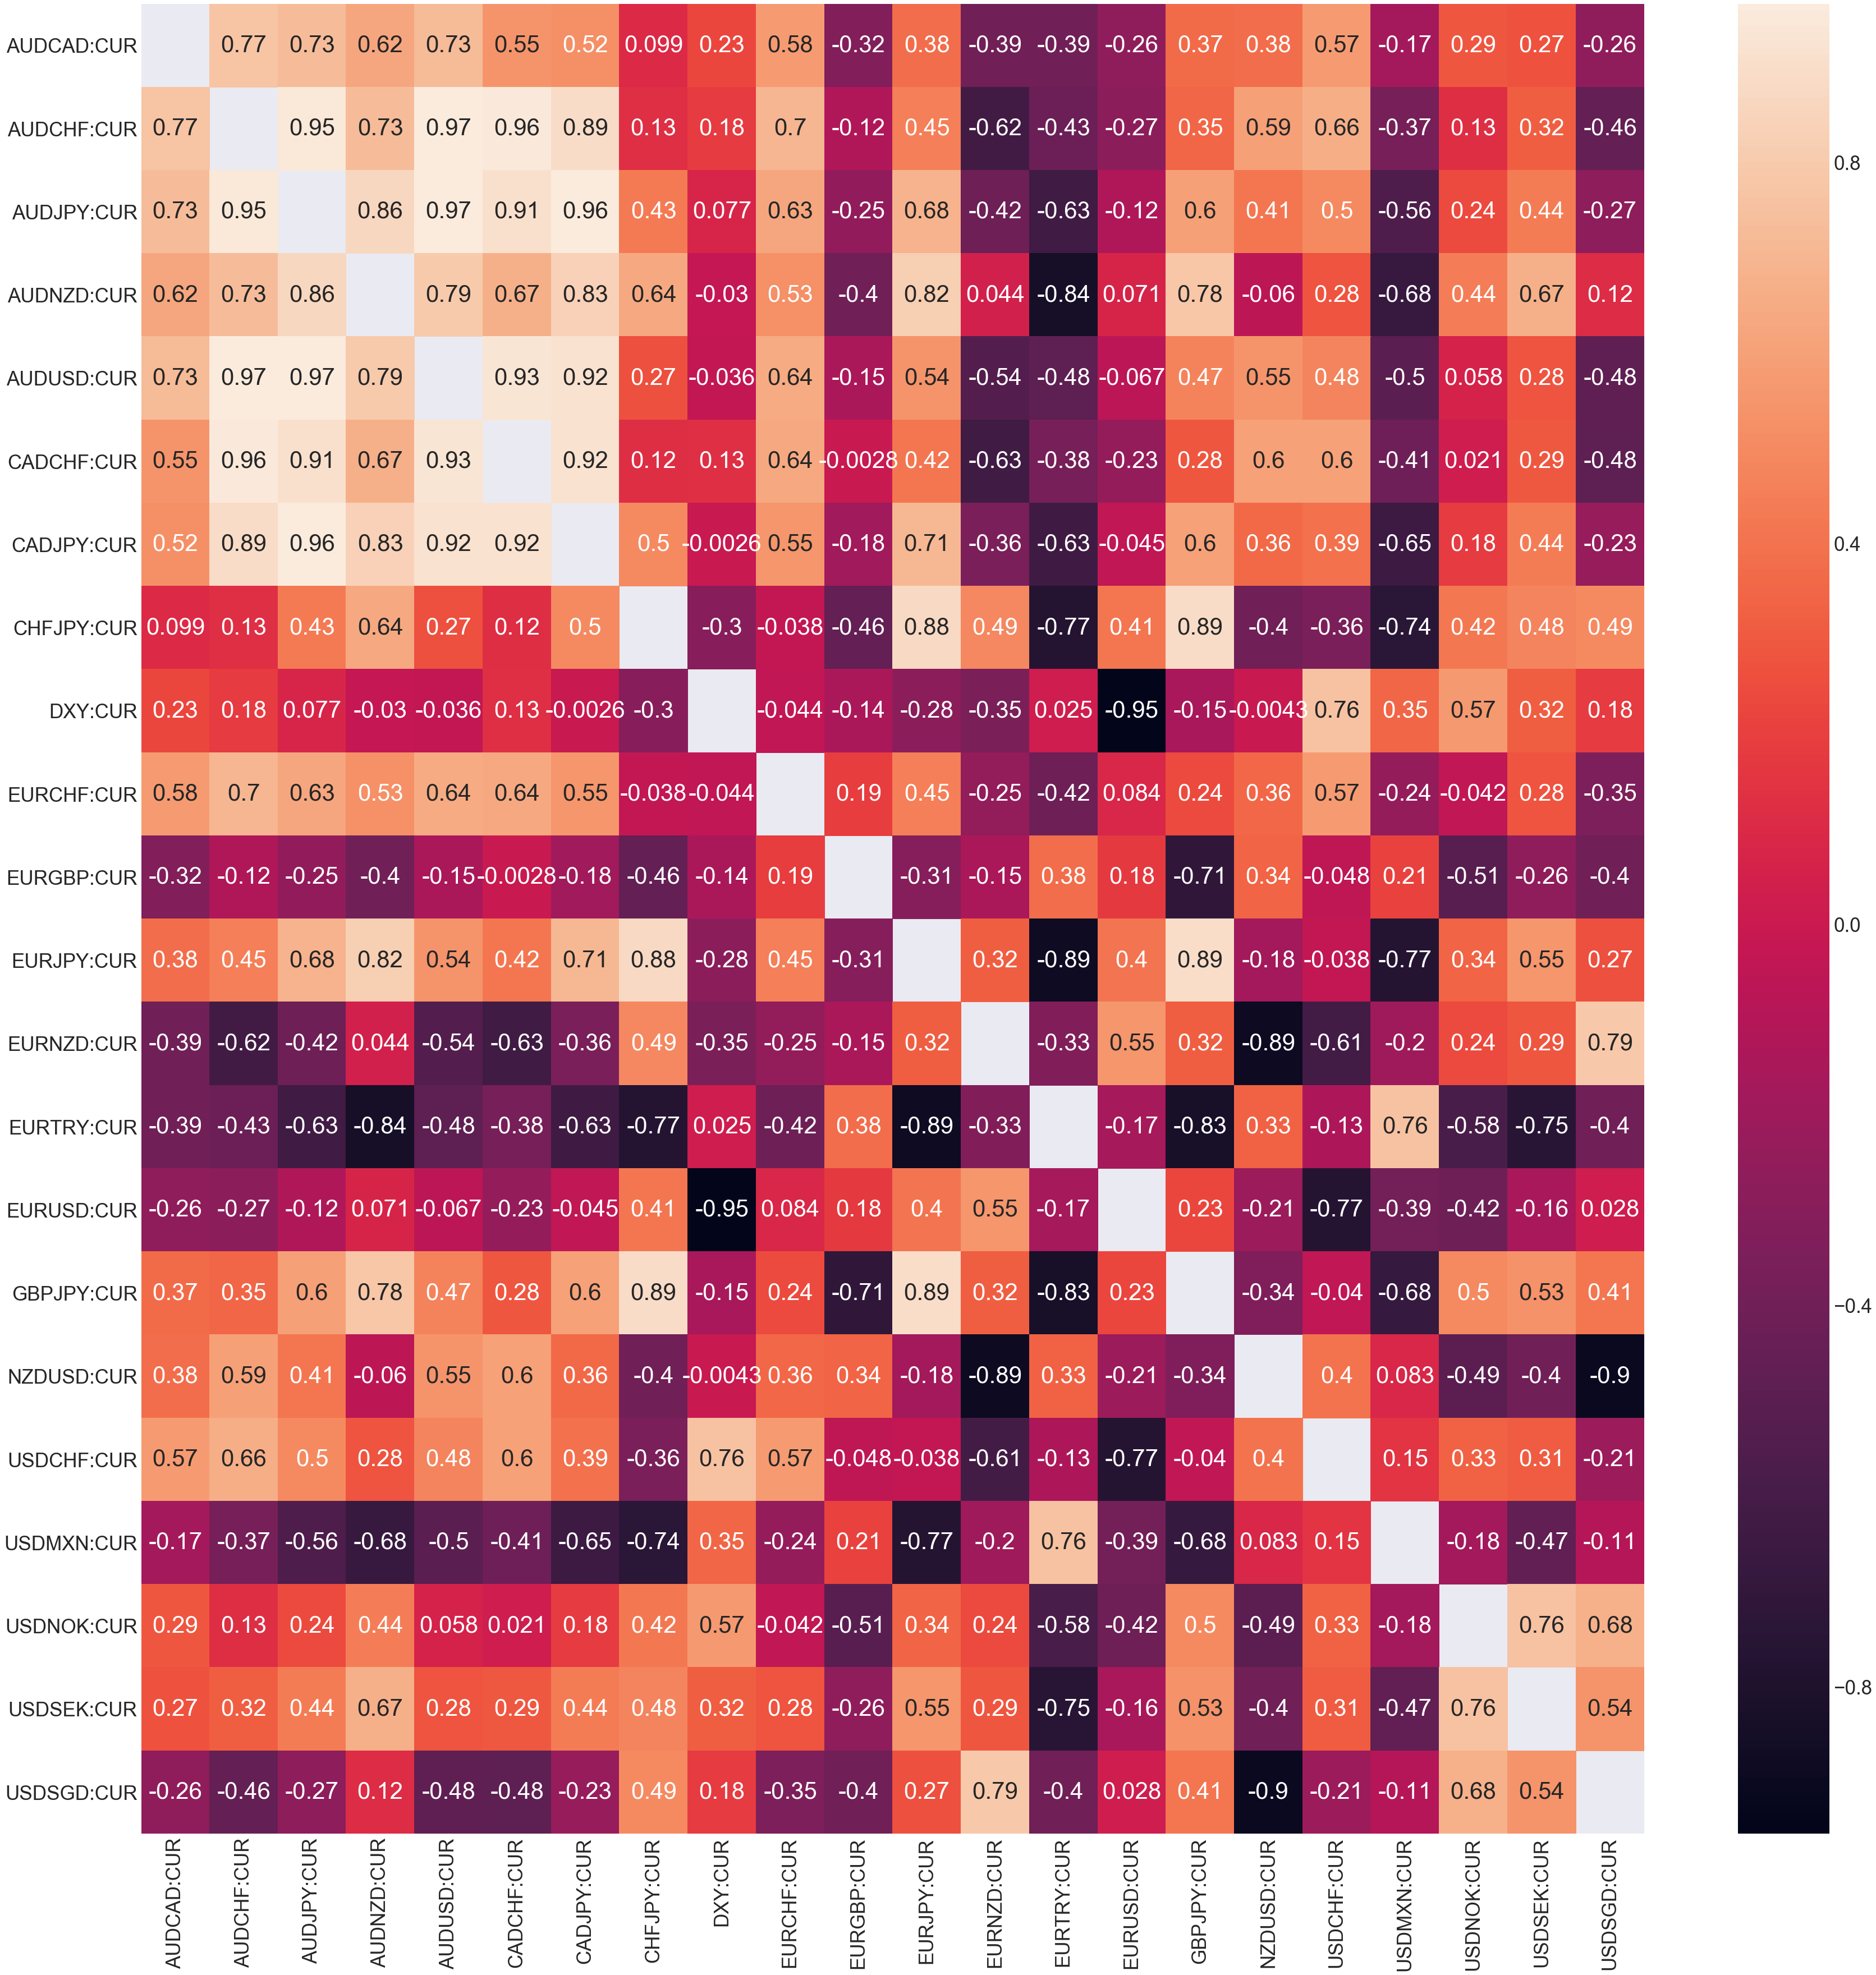

In [26]:
sns.set(rc={'figure.figsize':(60,60)})
sns.set_context("notebook", font_scale=3.5, rc={"lines.linewidth": 2.5})
sns.axes_style('axes.spines.top': True)
sns.heatmap(pd.DataFrame.from_dict(corr_matrix).astype(float), annot=True)  

In [28]:
def cointegration(df1, df2):
    comb_index = df1.index.union(df2.index)
    df1 = df1.reindex(comb_index, method='ffill').fillna(method='ffill')
    df2 = df2.reindex(comb_index, method='ffill').fillna(method='ffill')    
    engle_granger = ts.coint(df1.values,df2.values)
    beta_hr = sm.OLS(df1.values, df2.values).fit().params[0]
    res = df1.values - beta_hr * df2.values    
    # Calculate and reports the CADF test on the residuals
    adf = ts.adfuller(res.flatten())
    return engle_granger, adf

#coint_matrix_adf = pd.DataFrame(columns=tickers, index=tickers)
#coint_matrix_engle = pd.DataFrame(columns=tickers, index=tickers)
coint_matrix_adf = {}
coint_matrix_engle = {}
cointegrated_adf = {}
cointegrated_engle = {}
for t1 in tickers:
    coint_matrix_adf[t1] = {}
    coint_matrix_engle[t1] = {}
    cointegrated_adf[t1] = {}   
    cointegrated_engle[t1] = {}
    for t2 in tickers:
        if t2 == t1:
            continue
        coint_matrix_adf[t1][t2] = round(float(cointegration(data[t1]['Close'],data[t2]['Close'])[1][0]),4)
        if coint_matrix_adf[t1][t2] > .2:
            continue
        coint_matrix_engle[t1][t2] = round(float(cointegration(data[t1]['Close'],data[t2]['Close'])[0][0]),4)    
        if coint_matrix_engle[t1][t2] < -2.0:
            cointegrated_engle[t1][t2] = coint_matrix_engle[t1][t2]
        if coint_matrix_adf[t1][t2] < -2.0:
            cointegrated_adf[t1][t2] = coint_matrix_adf[t1][t2]    

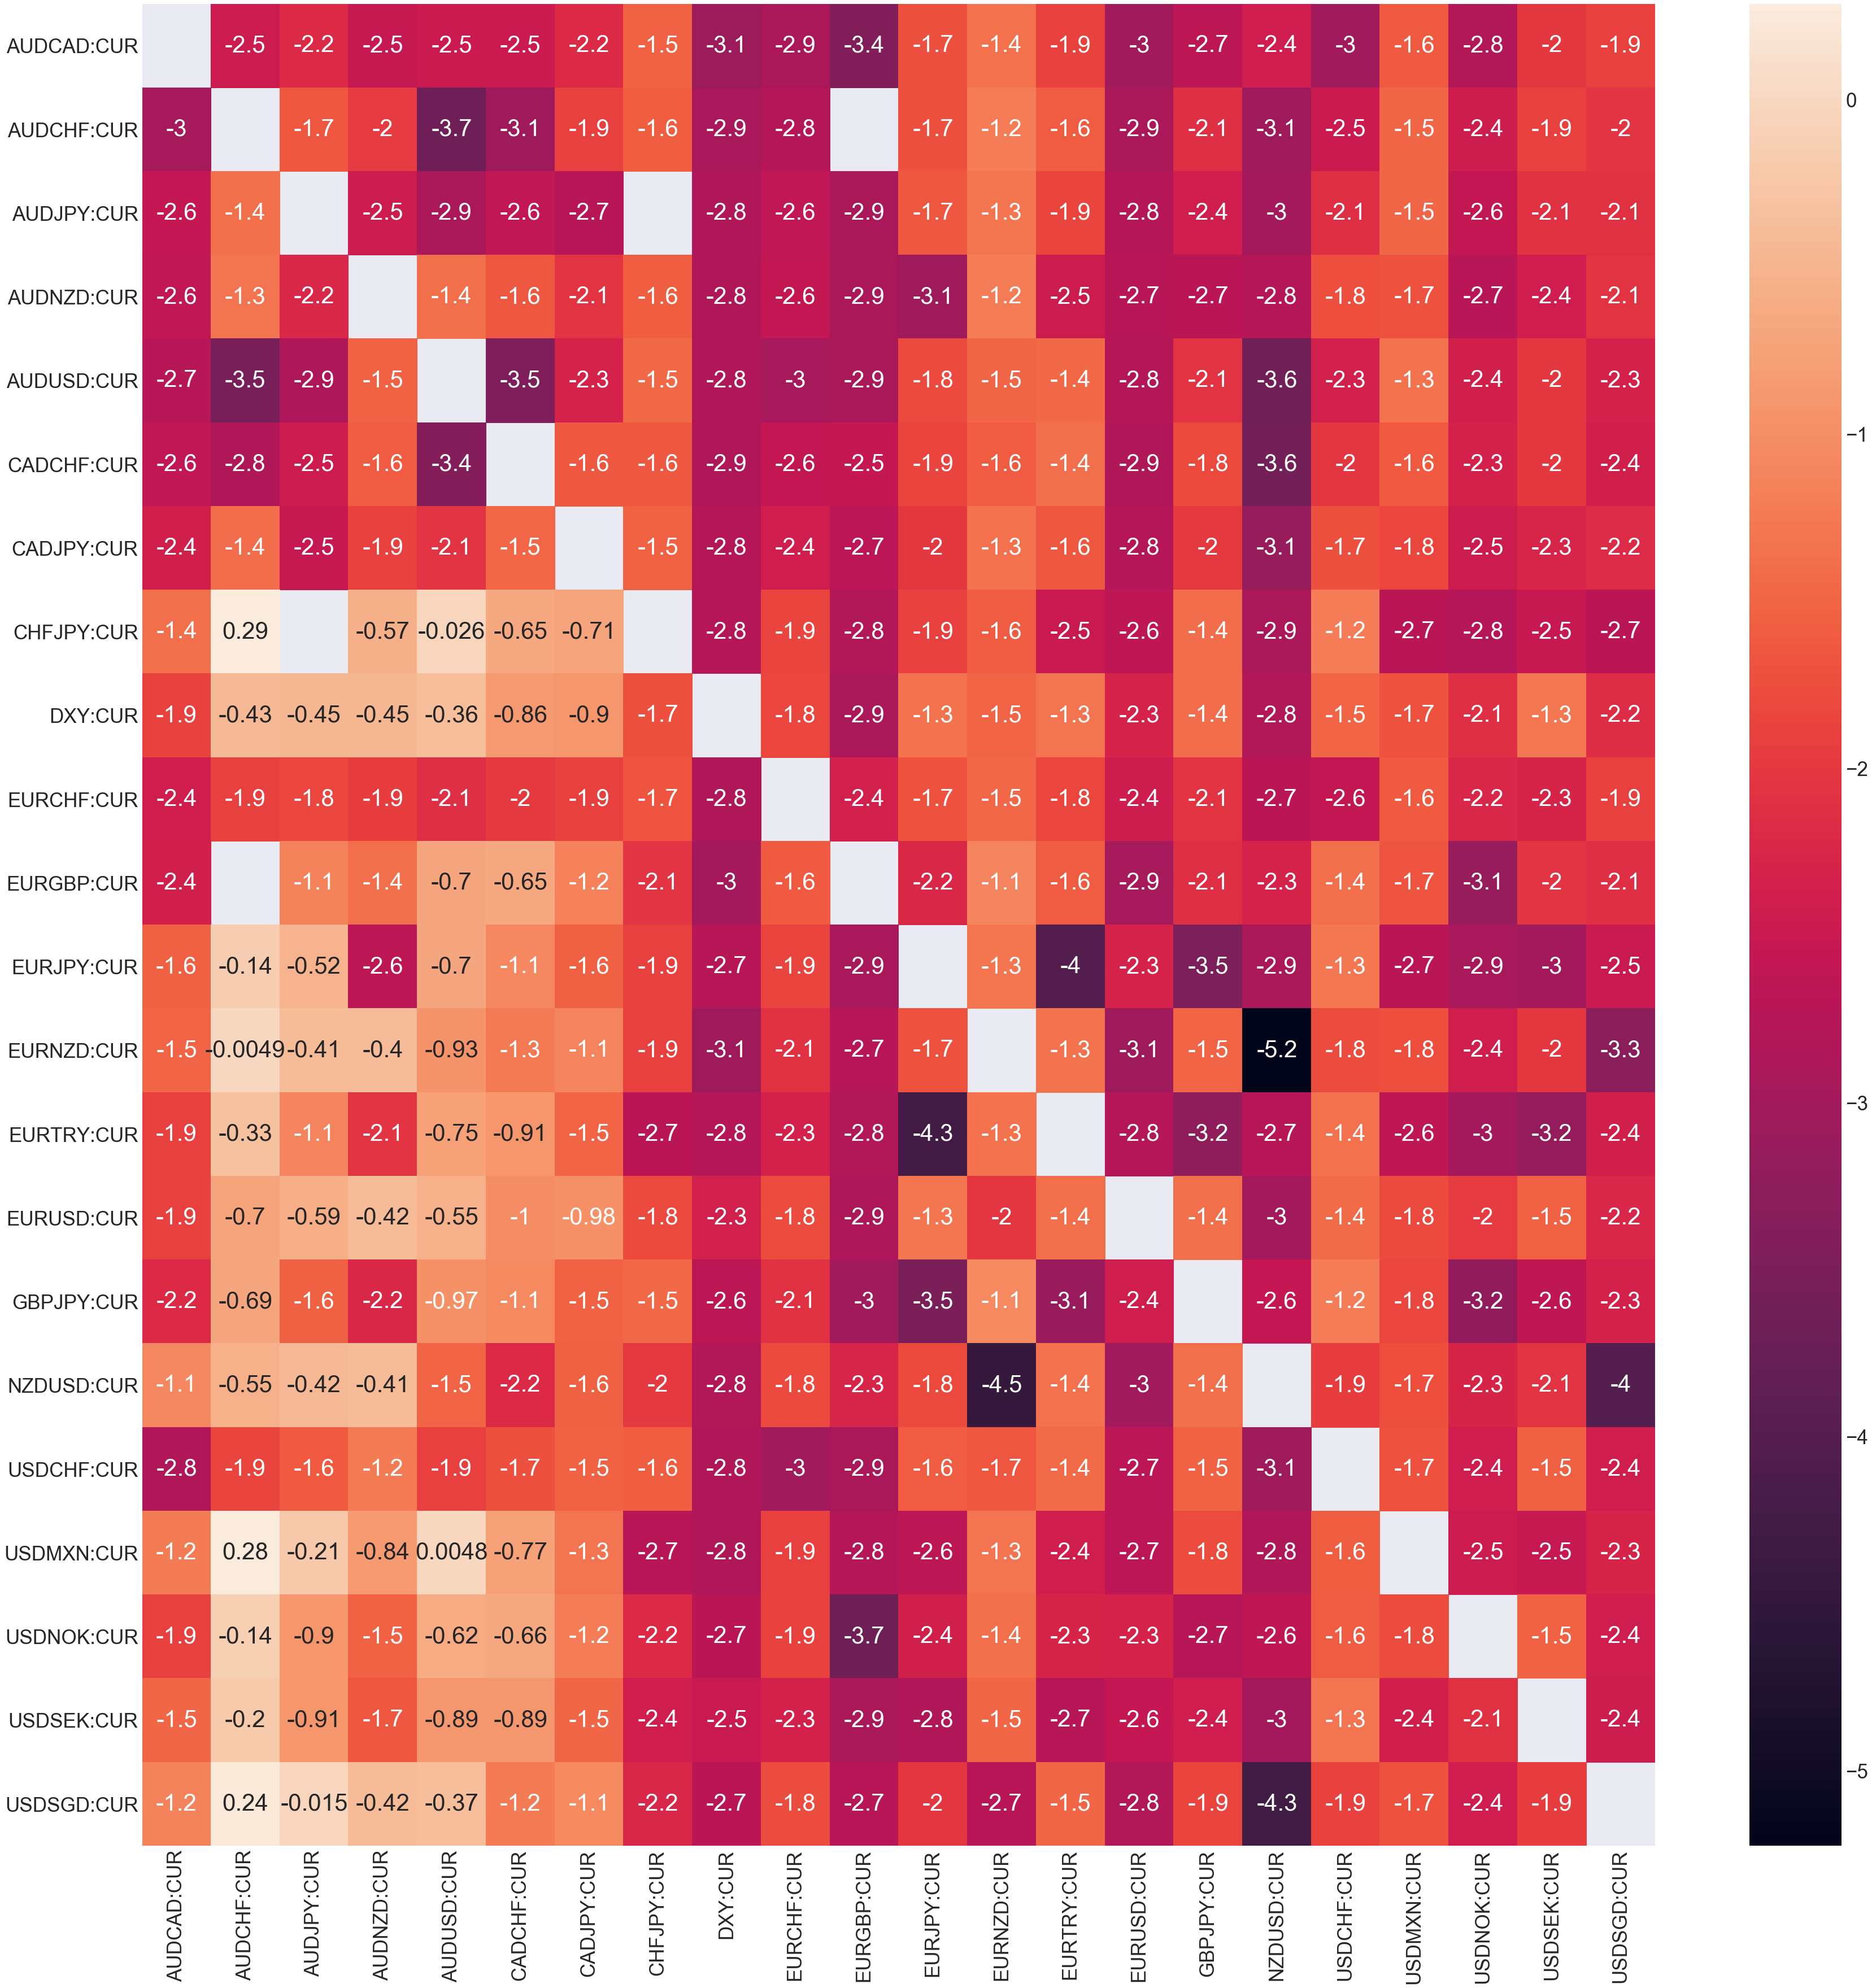

In [29]:
sns.set(rc={'figure.figsize':(60,60)})
sns.set_context("notebook", font_scale=3.5, rc={"lines.linewidth": 2.5})
sns.heatmap(pd.DataFrame.from_dict(coint_matrix_engle).astype(float), annot=True)  

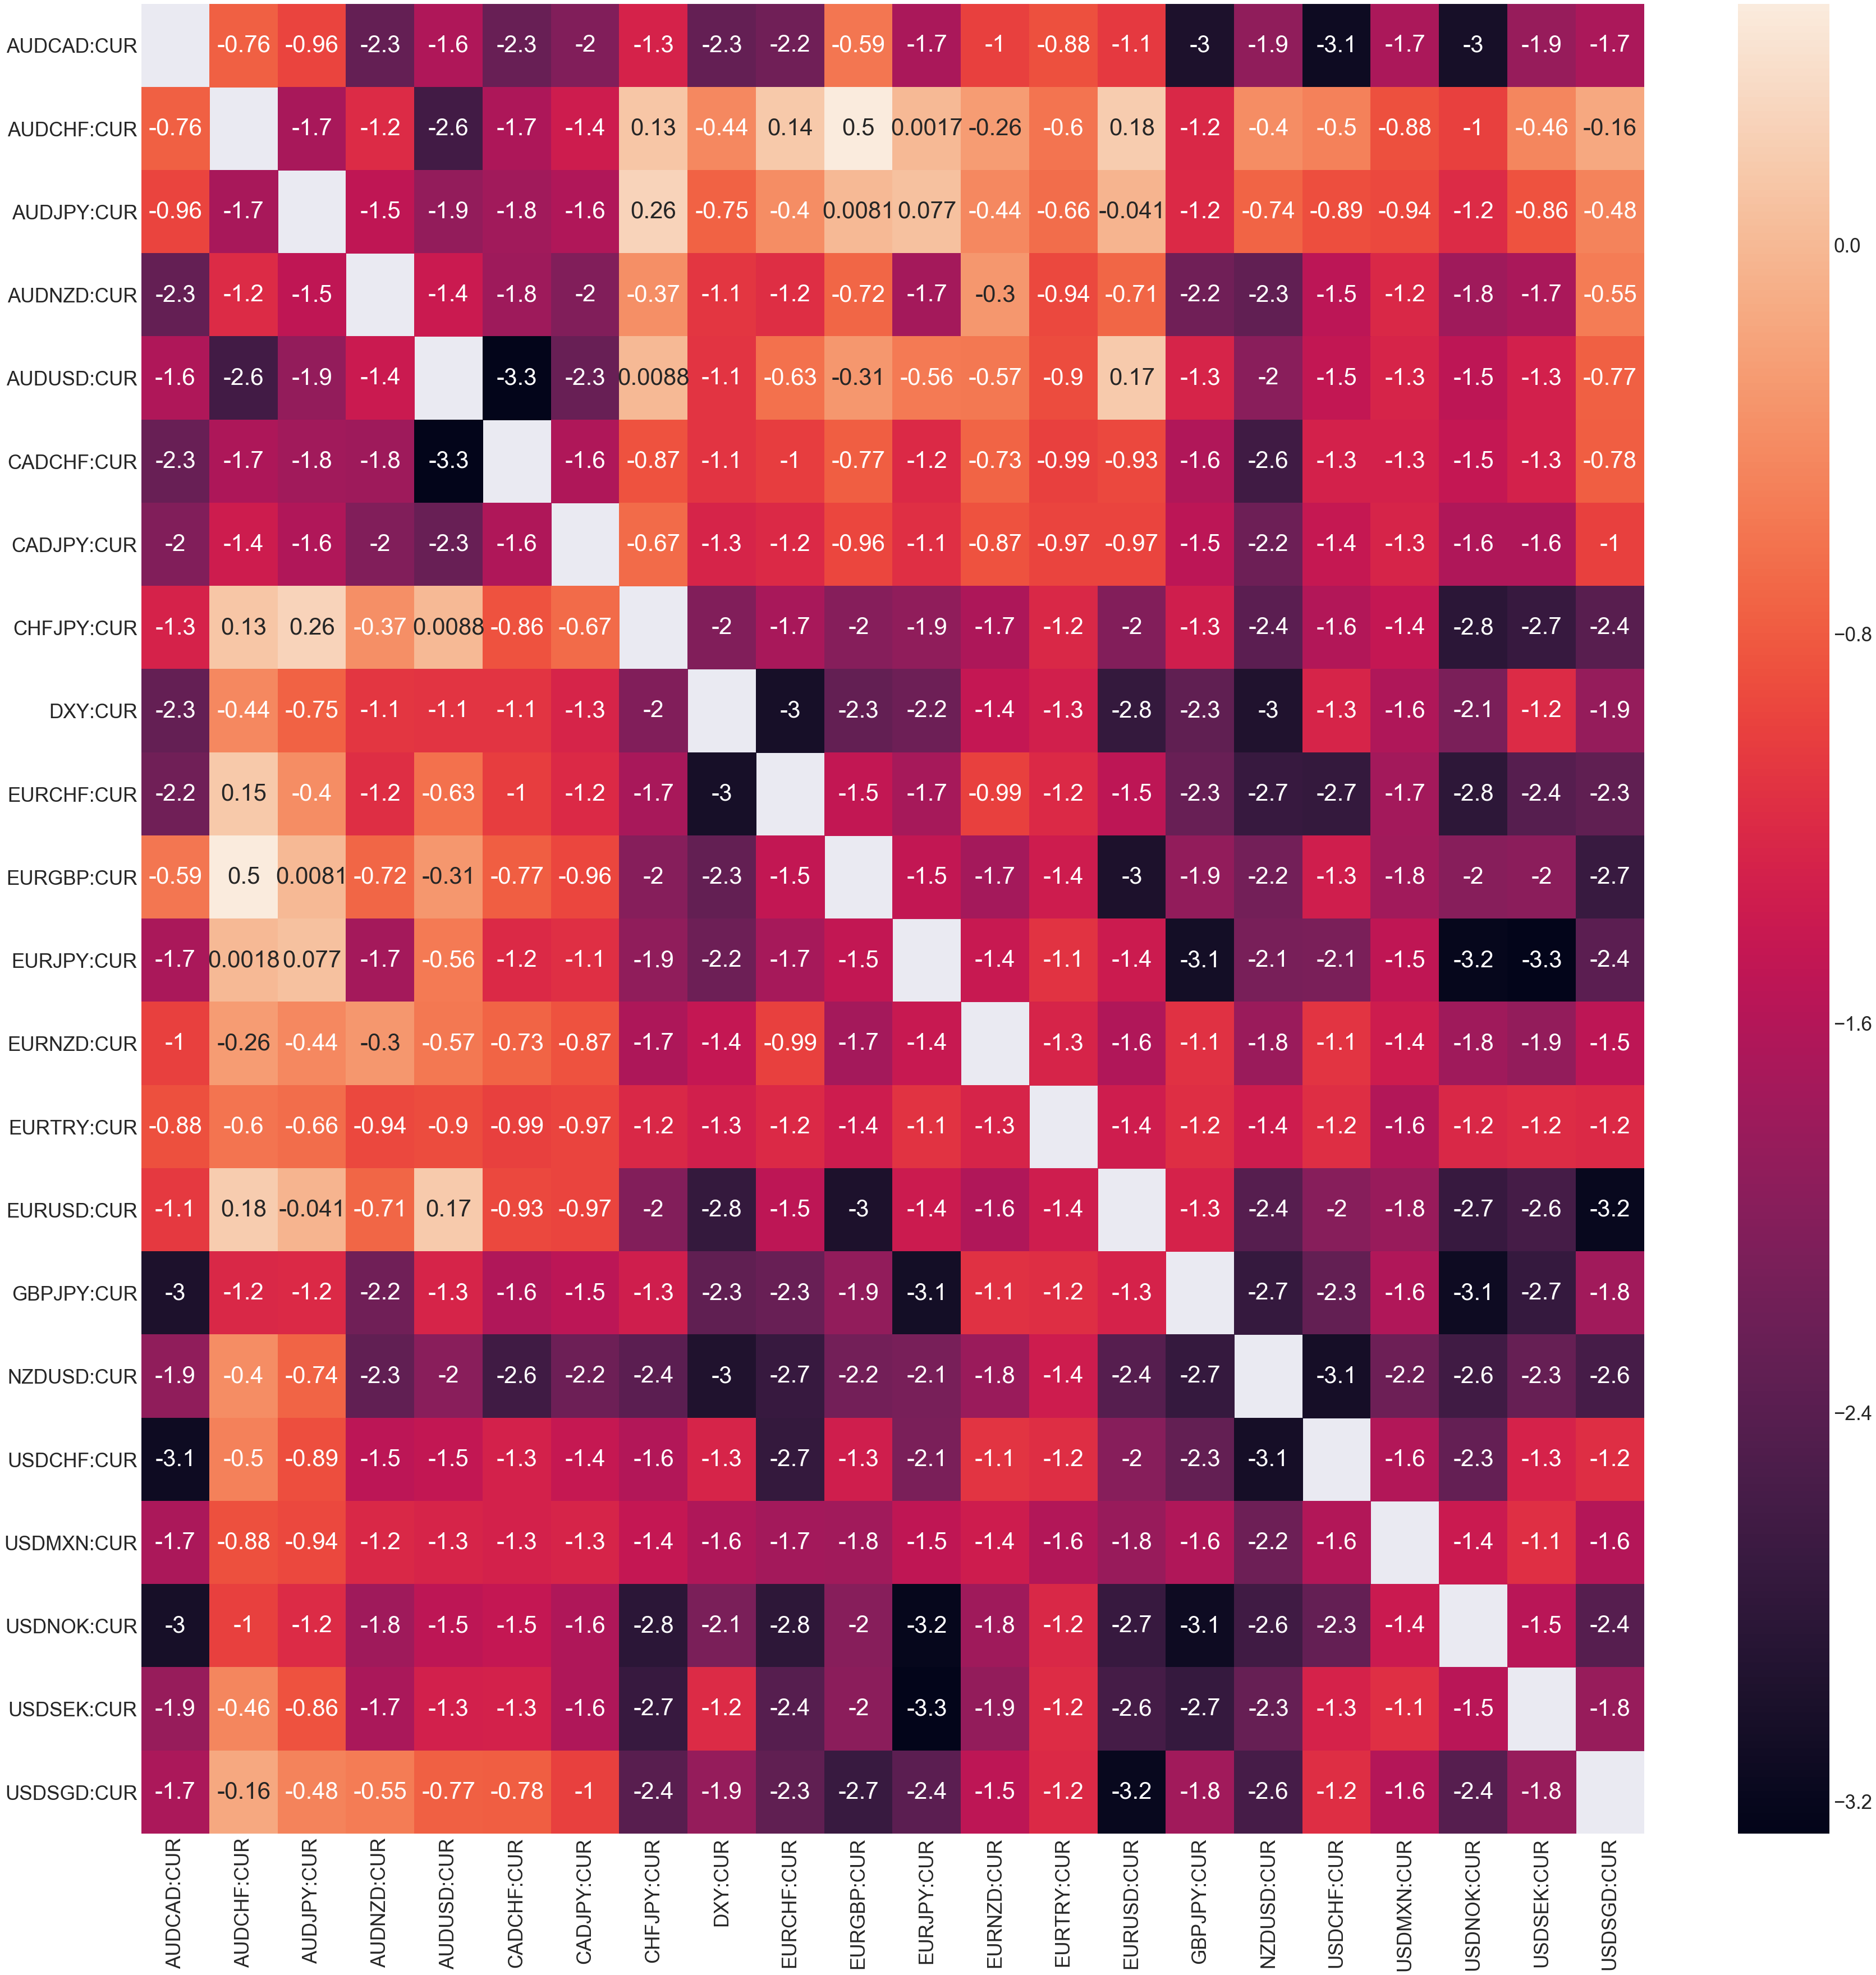

In [30]:
sns.set(rc={'figure.figsize':(60,60)})
sns.set_context("notebook", font_scale=3.5, rc={"lines.linewidth": 2.5})
sns.heatmap(pd.DataFrame.from_dict(coint_matrix_adf).astype(float), annot=True)  

In [32]:
pd.DataFrame.from_dict(coint_matrix_adf).to_csv('forex_adf')
pd.DataFrame.from_dict(coint_matrix_engle).to_csv('forex_engle')

In [34]:
for ticker in tickers:
    data[ticker].to_csv('{}.csv'.format(ticker.replace(':','-')))